In [1]:
import torch
import torchvision.models as models
import numpy as np
import torchvision
from torchsummary import summary

In [2]:
import torch.nn as nn

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        
        self.relu = nn.ReLU(inplace=False)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

    def forward(self, x):
        conv1_1 = self.relu(self.conv1_1(x))
        conv1_2 = self.relu(self.conv1_2(conv1_1))
        x = self.pool(conv1_2)

        conv2_1 = self.relu(self.conv2_1(x))
        conv2_2 = self.relu(self.conv2_2(conv2_1))
        x = self.pool(conv2_2)

        conv3_1 = self.relu(self.conv3_1(x))
        conv3_2 = self.relu(self.conv3_2(conv3_1))
        conv3_3 = self.relu(self.conv3_3(conv3_2))
        x = self.relu(self.conv3_4(conv3_3))
        x = self.pool(x)

        conv4_1 = self.conv4_1(x)
        x = self.relu(conv4_1)
        conv4_2 = self.relu(self.conv4_2(x))
        conv4_3 = self.relu(self.conv4_3(conv4_2))
        x = self.relu(self.conv4_4(conv4_3))
        x = self.pool(x)

        conv5_1 = self.relu(self.conv5_1(x))
        # conv5_2 = self.relu(self.conv5_2(conv5_1))
        # conv5_3 = self.relu(self.conv5_3(conv5_2))
        # x = self.relu(self.conv5_4(x))
        # x = self.pool5(x)

        # content = [conv1_2, conv2_2, conv3_2, conv4_2, conv5_2]
        content = [conv4_1]
        style = [conv1_1, conv2_1, conv3_1, conv4_1, conv5_1]

        return content, style


In [3]:
vgg = MyVGG()
vgg.eval()
vgg.requires_grad_(False)
dim = 1024
summary(vgg, (3, dim, dim), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 64, 1024, 1024]           1,792
              ReLU-2       [-1, 64, 1024, 1024]               0
            Conv2d-3       [-1, 64, 1024, 1024]          36,928
              ReLU-4       [-1, 64, 1024, 1024]               0
         MaxPool2d-5         [-1, 64, 512, 512]               0
            Conv2d-6        [-1, 128, 512, 512]          73,856
              ReLU-7        [-1, 128, 512, 512]               0
            Conv2d-8        [-1, 128, 512, 512]         147,584
              ReLU-9        [-1, 128, 512, 512]               0
        MaxPool2d-10        [-1, 128, 256, 256]               0
           Conv2d-11        [-1, 256, 256, 256]         295,168
             ReLU-12        [-1, 256, 256, 256]               0
           Conv2d-13        [-1, 256, 256, 256]         590,080
             ReLU-14        [-1, 256, 2

In [4]:
weights = torch.load('./weights_norm.pth')
model_dict = vgg.state_dict()
for layer_name in model_dict.keys():
    w = weights[layer_name].reshape(model_dict[layer_name].shape)
    model_dict[layer_name] = w.detach().clone()
vgg.load_state_dict(model_dict)

<All keys matched successfully>

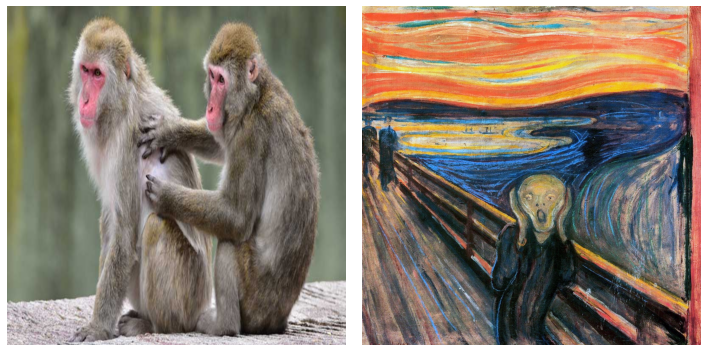

In [5]:
import cv2
import matplotlib.pyplot as plt

content_img = cv2.resize(cv2.imread('./content_sample2.jpg')[..., ::-1], (dim, dim))
style_img = cv2.resize(cv2.imread('./style_sample3.jpeg')[..., ::-1], (dim, dim))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(content_img); axes[0].axis('off')
axes[1].imshow(style_img); axes[1].axis('off')

plt.tight_layout(); plt.show()


In [6]:
device = 'cuda'
vgg = vgg.to(device)
next(vgg.parameters()).device

device(type='cuda', index=0)

In [7]:
def preprocess(img):
    prep_img = torch.tensor(img / 255, dtype=torch.float32)
    prep_image = (prep_img - torch.tensor([0.485, 0.456, 0.406])) / torch.tensor([0.229, 0.224, 0.225])
    prep_image = prep_image.permute(2, 0, 1).unsqueeze(0)
    return prep_image.contiguous().to(device)

In [8]:
with torch.no_grad():
    target_content, _ = vgg(preprocess(content_img))
    _, target_style = vgg(preprocess(style_img))

In [9]:
def gram(s):
    s_flat = s.reshape((*s.shape[:2], -1))
    return (s_flat @ s_flat.permute(0, 2, 1))[0]

In [10]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


2024-03-24 19:36:14.338071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 19:36:14.338098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 19:36:14.338905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-24 19:36:14.343092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 19:36:15.019577: W tensorflow/compiler/tf2

In [11]:
running_loss = 0.
style_loss = 0.
content_loss = 0.
last_loss = 0.
steps = 100000

beta = 1e+6
alpha = 5e-4 * beta

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/style_transfer_{}'.format(timestamp))

target_gram = [gram(s) for s in target_style]
norm_factor = 1 / np.array([4 * s.shape[1] * s.shape[2] * s.shape[3] for s in target_style])
mse_loss = torch.nn.MSELoss(reduction='sum')

x_image = np.random.uniform(0, 1, size=(1, 3, dim, dim))
x_image = torch.tensor(x_image, dtype=torch.float32, requires_grad=True).to(device)
x_image = torch.nn.Parameter(x_image)
# optimizer = torch.optim.Adam([x_image], lr=1e-2)
optimizer = torch.optim.LBFGS([x_image], lr=1e-2, max_iter=10, max_eval=None, tolerance_grad=1e-07,
                              tolerance_change=1e-09, history_size=100, line_search_fn=None)

# L-BFGS
def closure():
    global loss, style_loss, content_loss
    optimizer.zero_grad()
    content, style = vgg(x_image)

    style_gram = [gram(s) for s in style]

    # Loss
    style_loss = sum([w * mse_loss(g_hat, g_target) for w, g_hat, g_target in zip(norm_factor, style_gram, target_gram)])
    content_loss = mse_loss(content[0], target_content[0])

    loss = beta * 1 / 5 * style_loss + alpha * content_loss
    loss.backward()
    return loss


for i in range(steps):
    optimizer.step(closure=closure)

    # Gather data and report
    running_loss += loss.item()
    style_loss += style_loss.item()
    content_loss += content_loss.item()
    if i % 10 == 0:
        last_loss = running_loss / 10 # loss per batch
        last_loss_content = content_loss / 10 # loss per batch
        last_loss_style = style_loss / 10 # loss per batch
        print('  batch {} loss: {}'.format(i + 1, last_loss))
        tb_x = i + 1
        writer.add_scalar('TotalLoss/train', last_loss, tb_x)
        writer.add_scalar('ContentLoss/train', last_loss, tb_x)
        writer.add_scalar('StyleLoss/train', last_loss, tb_x)

        img_grid = torchvision.utils.make_grid(x_image)
        writer.add_image('Generated Image', img_grid, tb_x)

        running_loss = 0.
        style_loss = 0.
        content_loss = 0.

  batch 1 loss: 4391934.4
  batch 11 loss: 28371402.8
  batch 21 loss: 19812112.0
  batch 31 loss: 16643404.9
  batch 41 loss: 15016396.6
  batch 51 loss: 13985341.1
  batch 61 loss: 13242089.0
  batch 121 loss: 11292444.6
  batch 131 loss: 11094005.8
  batch 141 loss: 10909439.0
  batch 151 loss: 10739874.2
  batch 161 loss: 10586245.7
  batch 171 loss: 10449918.6
  batch 181 loss: 10332710.9
  batch 191 loss: 10233792.3
  batch 201 loss: 10151219.3
  batch 211 loss: 10082561.3
  batch 221 loss: 10025243.4
  batch 231 loss: 9977735.7
  batch 241 loss: 9938247.1
  batch 251 loss: 9905281.3
  batch 261 loss: 9877728.0
  batch 271 loss: 9854979.2
  batch 281 loss: 9835882.4
  batch 291 loss: 9819582.9
  batch 301 loss: 9805835.8
  batch 311 loss: 9794325.6
  batch 321 loss: 9784493.9
  batch 331 loss: 9775960.4
  batch 341 loss: 9768765.7
  batch 351 loss: 9762541.2
  batch 361 loss: 9757204.1
  batch 371 loss: 9752698.1
  batch 381 loss: 9748748.8
  batch 391 loss: 9745313.6
  batch 401

KeyboardInterrupt: 